In [19]:
import pandas as pd
import acquire
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [21]:
canada, mexico = acquire.get_data()
mexico

,port_name,state,port_code,border,date,crossing_method,n_crossings
3,Brownsville,TX,2301,US-Mexico Border,2019-12-01,Bus Passengers,4668
6,Calexico East,CA,2507,US-Mexico Border,2019-12-01,Bus Passengers,4080
8,Columbus,NM,2406,US-Mexico Border,2019-12-01,Bus Passengers,1452
11,Douglas,AZ,2601,US-Mexico Border,2019-12-01,Bus Passengers,107
13,Eagle Pass,TX,2303,US-Mexico Border,2019-12-01,Bus Passengers,8525
...,...,...,...,...,...,...,...
353936,Douglas,AZ,2601,US-Mexico Border,1996-01-01,Trains,0
353937,San Ysidro,CA,2504,US-Mexico Border,1996-01-01,Rail Containers Full,0
353938,Santa Teresa,NM,2408,US-Mexico Border,1996-01-01,Personal Vehicles,4719
353945,Presidio,TX,2403,US-Mexico Border,1996-01-01,Pedestrians,645


In [29]:
def min_max_scale_column(col):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(col.values.reshape(-1, 1)) # fit_transform needs a 2 dimensional input
    return pd.Series(scaled[:, 0], index=col.index) # set the index back to the original and return a 1 dimensional series

In [32]:
mx_ports = (mexico.
 set_index("date")
 .sort_index()
 ["2015":"2019"]
 .pivot_table(values="n_crossings", index="port_name", columns="crossing_method", aggfunc="median")
.fillna(0)
.apply(min_max_scale_column))

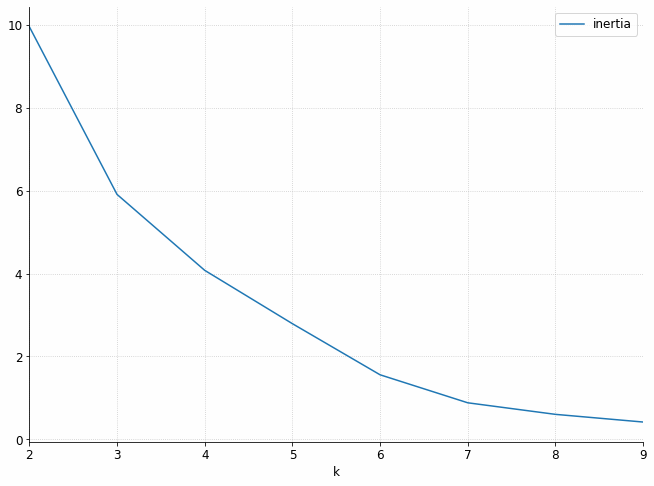

In [44]:
# Lets use the elbow method to figure out how many K to use in KMeans
# Plot inertia vs k

data = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(mx_ports)
    data.append({"k": k, "inertia":kmeans.inertia_})

pd.DataFrame(data).set_index("k").plot()

In [47]:
# For sake of time and complexity and unbalanced data, we'll move forward with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=123).fit(mx_ports)
mx_clusters = pd.Series(kmeans.predict(mx_ports), index=mx_ports.index, name="port_clusters")
mx_clusters

port_name
Andrade                0
Boquillas              0
Brownsville            0
Calexico               0
Calexico East          0
Columbus               0
Cross Border Xpress    0
Del Rio                0
Douglas                0
Eagle Pass             0
El Paso                1
Hidalgo                0
Laredo                 1
Lukeville              0
Naco                   0
Nogales                0
Otay Mesa              1
Presidio               0
Progreso               0
Rio Grande City        0
Roma                   0
San Luis               0
San Ysidro             1
Santa Teresa           0
Sasabe                 0
Tecate                 0
Tornillo-Fabens        0
Name: port_clusters, dtype: int32

In [54]:
# Set the index to port_name
mexico = mexico.set_index("port_name").join(mx_clusters).reset_index()

In [57]:
mexico.set_index("date").groupby('port_cluster', ""])

,port_name,state,port_code,border,date,crossing_method,n_crossings,port_clusters
0,Andrade,CA,2502,US-Mexico Border,2019-12-01,Pedestrians,85352,0
1,Andrade,CA,2502,US-Mexico Border,2019-12-01,Personal Vehicle Passengers,90723,0
2,Andrade,CA,2502,US-Mexico Border,2019-12-01,Personal Vehicles,47263,0
3,Andrade,CA,2502,US-Mexico Border,2019-11-01,Pedestrians,86605,0
4,Andrade,CA,2502,US-Mexico Border,2019-11-01,Personal Vehicle Passengers,90726,0
...,...,...,...,...,...,...,...,...
82283,Tornillo-Fabens,TX,2404,US-Mexico Border,1996-01-01,Trains,0,0
82284,Tornillo-Fabens,TX,2404,US-Mexico Border,1996-01-01,Train Passengers,0,0
82285,Tornillo-Fabens,TX,2404,US-Mexico Border,1996-01-01,Pedestrians,2275,0
82286,Tornillo-Fabens,TX,2404,US-Mexico Border,1996-01-01,Rail Containers Empty,0,0
